In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from tqdm import tqdm 

In [6]:
# load either catsndogs or tcga data set 
def load_data(tcga=True):
    if tcga: 
        file_path_data = "TCGAdata.txt"
        file_path_labels = "TCGAlabels.txt"
        delimiter=' '
    else:
        file_path_data = "CATSnDOGS.csv"
        file_path_labels = "Labels.csv"
        delimiter=',' 
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(file_path_labels, delimiter=delimiter, header=0, quotechar='"')
    return df_data.values, df_labels.values 

# find optimal number of features 
def feature_selection(data, labels, classifier):
    sel = VarianceThreshold(threshold=5.0)
    data_cleaned = sel.fit_transform(data)
    #X_test = sel.transform(X_test)

    max_features = min(100, data_cleaned.shape[1])
    feature_range = range(1, max_features + 1, 5)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_score = 0
    best_num_features = 0 
    best_features = None 
    best_data_feature_reduced = None 
    for n_features in feature_range:
        anova = SelectKBest(score_func=f_classif, k=n_features)
        data_feature_reduced = anova.fit_transform(data_cleaned, labels)
        cv_scores = cross_val_score(classifier, data_feature_reduced, labels, cv=kf)
        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_num_features = n_features
            # Get the mask of selected features
            best_features_mask = anova.get_support()
            # Get the names of the selected features
            best_features = np.where(best_features_mask == True)[0]  
            best_data_feature_reduced = data_feature_reduced
    print(f"#features: {best_num_features}, score: {best_score}") 
    return best_features, best_num_features 


def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def add_noise_to_matrix(matrix, noise_percent, tcga=True):
    total_data_points = matrix.size
    num_noisy_features = int((noise_percent / 100.0) * total_data_points)
    noisy_matrix = np.copy(matrix)

    # Get random indices to add noise to
    indices_to_noise = np.random.choice(total_data_points, num_noisy_features, replace=False)

    if len(indices_to_noise) > 0:
        chosen_indices = np.unravel_index(indices_to_noise, matrix.shape)

        for i, j in zip(chosen_indices[0], chosen_indices[1]):
            # Add random noise to the selected indices
            if tcga:
                noise = np.random.uniform(low=np.min(matrix), high=np.max(matrix))
            else:
                noise = np.random.randint(low=np.min(matrix), high=np.max(matrix))
            noisy_matrix[i][j] += noise 

    return noisy_matrix

100%|██████████| 10/10 [30:50<00:00, 185.05s/it]


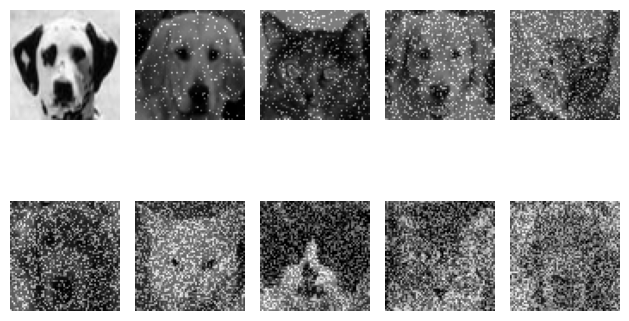

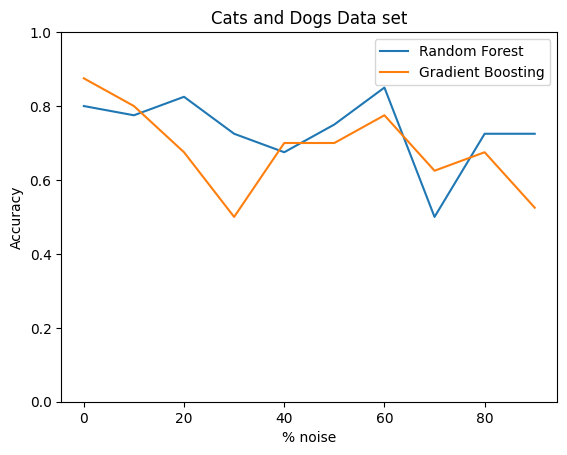

In [7]:
import warnings
warnings.filterwarnings('ignore')

accuracies_rf = []
accuracies_gb = []
noise_range = np.linspace(0, 90, 10)
classifier_rf = RandomForestClassifier(n_estimators=100, max_depth=9)  # 500
classifier_gb = GradientBoostingClassifier(n_estimators=200, max_depth=6)

feature_importance_rf = []
best_features_rf = []
feature_importance_gb = []
best_features_gb = []

i=0

for noise in tqdm(noise_range):
    i+=1 

    data, labels = load_data(tcga=False)
    noisy_matrix = add_noise_to_matrix(data, noise, tcga=False)
    X_train, X_test, y_train, y_test = train_test_split(noisy_matrix, labels, test_size=0.2)

    anova = SelectKBest(score_func=f_classif, k=1000)  # 1000
    X_train_feature = anova.fit_transform(X_train, y_train.ravel())
    X_test_feature = anova.transform(X_test)
    best_features_mask = anova.get_support()
    best_features = np.where(best_features_mask == True)[0] 

    X_train_stand, X_test_stand = standardize(X_train_feature, X_test_feature)

    plt.subplot(2, 5, i)  
    plt.imshow(X_train[0].reshape(64, 64).T, cmap='gray')  
    plt.axis('off')  
    for classifier in [classifier_rf, classifier_gb]:
        classifier.fit(X_train_stand, y_train.ravel())
        y_pred_test = classifier.predict(X_test_stand)
        accuracy = accuracy_score(y_test, y_pred_test)

        feature_importances = classifier.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]
        sorted_feature_importance = feature_importances[sorted_indices]
        sorted_best_features = best_features[sorted_indices]

        if type(classifier) == type(classifier_rf):
            accuracies_rf.append(accuracy)
            feature_importance_rf.append(sorted_feature_importance)
            best_features_rf.append(sorted_best_features)
        else:
            accuracies_gb.append(accuracy)
            feature_importance_gb.append(sorted_feature_importance)
            best_features_gb.append(sorted_best_features)
plt.tight_layout() 
plt.show()
plt.plot(noise_range, accuracies_rf, label="Random Forest")
plt.plot(noise_range, accuracies_gb, label="Gradient Boosting")
plt.title("Cats and Dogs Data set")
plt.xlabel("% noise")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

Top 10 common features for noise 0.0: []
Top 10 common features for noise 10.0: [1509 1704 2192 2454 2516]
Top 10 common features for noise 20.0: [ 146  265 1236 4081]
Top 10 common features for noise 30.0: [1425 1721 1737 2065 2195 3128]
Top 10 common features for noise 40.0: [1230 1742 1750 1917 2065 2389]
Top 10 common features for noise 50.0: [ 393 1462 2137]
Top 10 common features for noise 60.0: [1967 2042 2061 2386 2514 4062]
Top 10 common features for noise 70.0: [ 514 2064 2100 2317 2512 3189 3577]
Top 10 common features for noise 80.0: [1294 2194]
Top 10 common features for noise 90.0: [2137 2195 2423 2545]


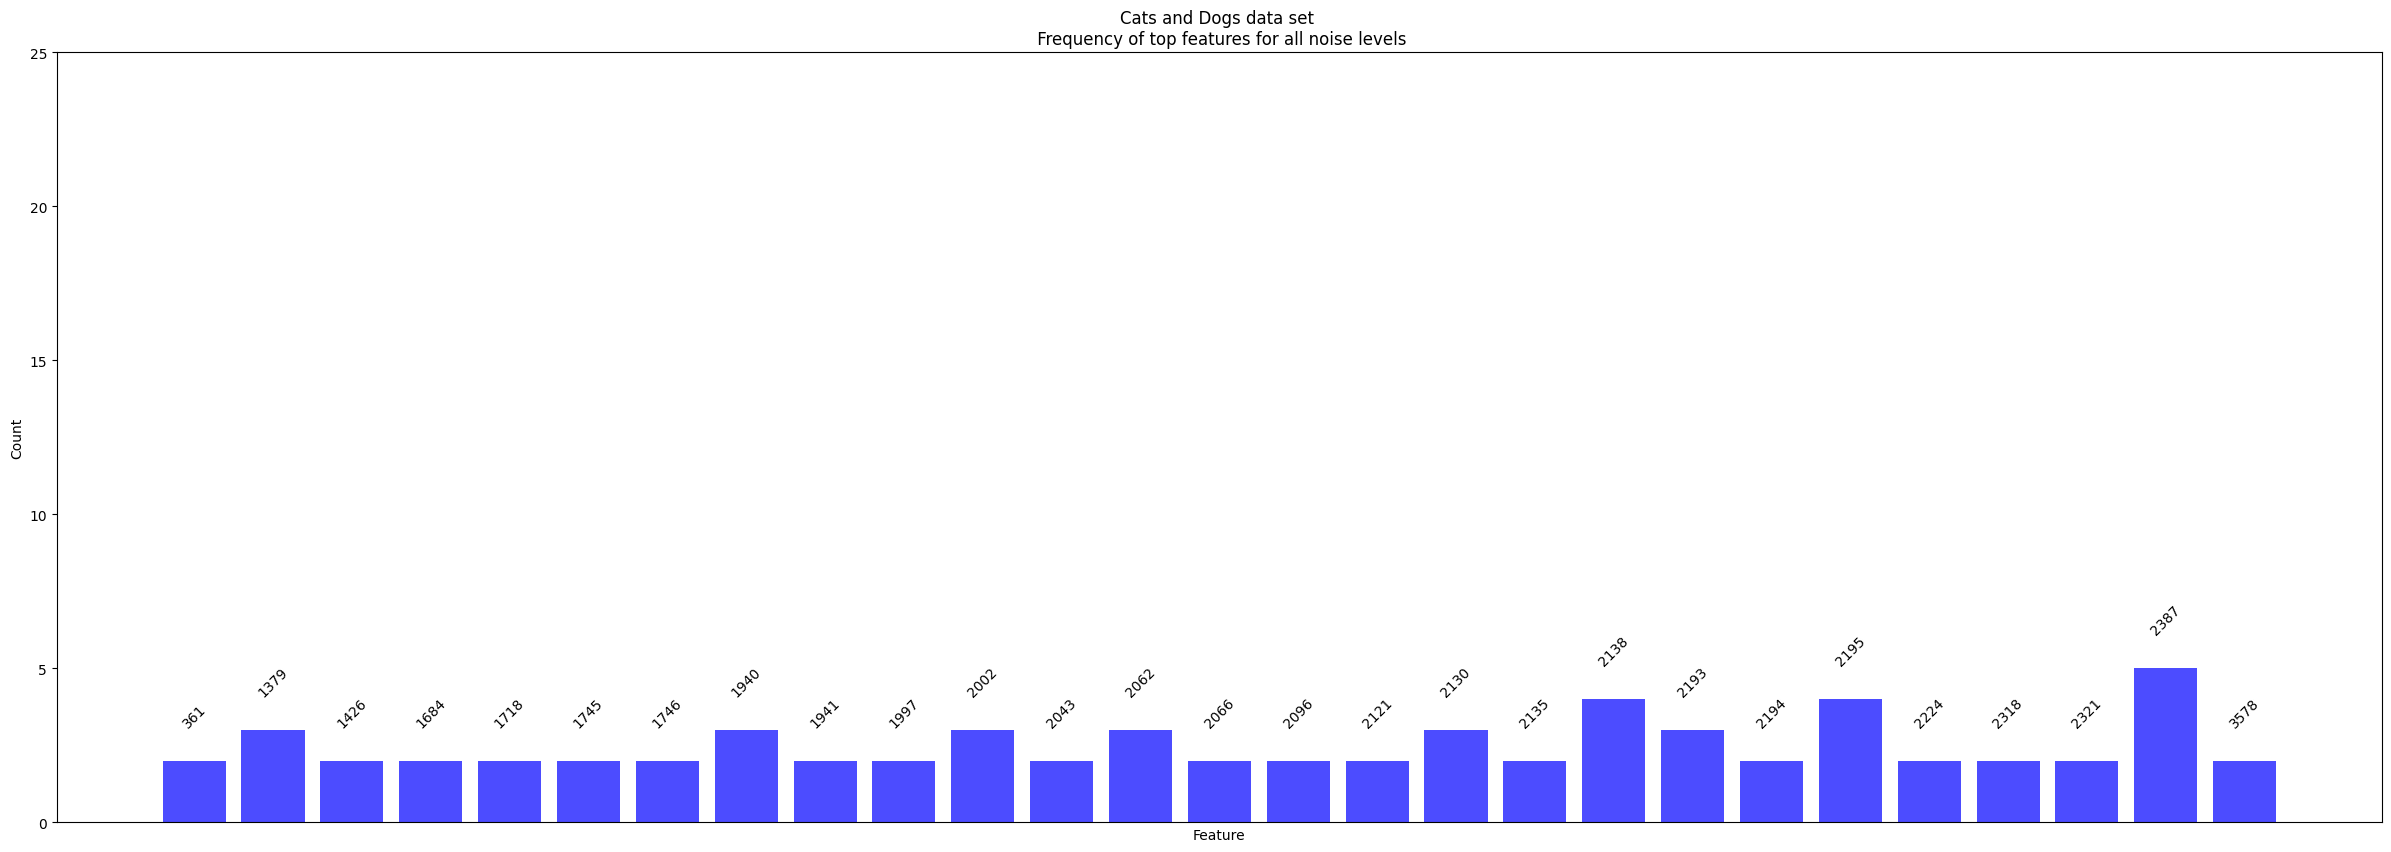

[ 361 1379 1426 1684 1718 1745 1746 1940 1941 1997 2002 2043 2062 2066
 2096 2121 2130 2135 2138 2193 2194 2195 2224 2318 2321 2387 3578]


In [12]:
# Inspect what features are getting chosen

overall = np.zeros(data.shape[1])
matches = []
for i, noise in enumerate(noise_range):
    overall[best_features_rf[i][:10]] += 1 
    overall[best_features_gb[i][:10]] += 1 
    common_values = np.intersect1d(best_features_rf[i][:50], best_features_gb[i][:50], return_indices=False)
    print(f"Top 10 common features for noise {round(noise, 1)}: {common_values[:100]}")
    matches.append(len(common_values))

#plt.plot(noise_range, matches)
#plt.xlabel("noise percent")
#plt.ylabel("number of matches")
#plt.show()     

last_non_zero_idx = len(overall) - np.argmax(overall[::-1] != 0) - 1
overall = overall[:last_non_zero_idx + 1]

count = overall[overall >= 2]
features = np.where(overall >= 2)[0]
plt.figure(figsize=(30,10))
bars = plt.bar(np.arange(1, len(count)+1), count, color='blue', alpha=0.7)
for bar, value in zip(bars, features):
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width() / 2,  # X coordinate for text (center of the bar)
            yval + 1,  # Y coordinate for text (slightly above the bar)
            value + 1,  # Text value (rounded to 2 decimal places)
            ha='center', va='bottom', fontsize=10, color='black', rotation=45)
plt.title("Cats and Dogs data set \n Frequency of top features for all noise levels")
plt.xlabel("Feature")
plt.ylabel("Count")  
plt.ylim([0, 25])
plt.xticks([])
plt.show()
print(features + 1)


1131


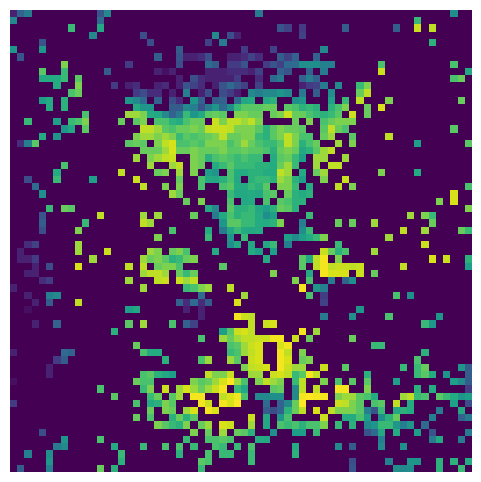

In [9]:
overall = np.zeros(data.shape[1])
matches = []
for i, noise in enumerate(noise_range):
    overall[best_features_rf[i][:100]] += 1 
    overall[best_features_gb[i][:100]] += 1 
features = np.where(overall > 0)[0] 
print(len(features))
image = data[0]
image_reduced = np.zeros_like(image)

# Replace elements at specified indices with the original values
image_reduced[features] = image[features]

image_reduced = image_reduced.reshape(64, 64).T
plt.figure(figsize=(6, 6))  
plt.imshow(image_reduced)  
plt.axis('off')  
plt.show()

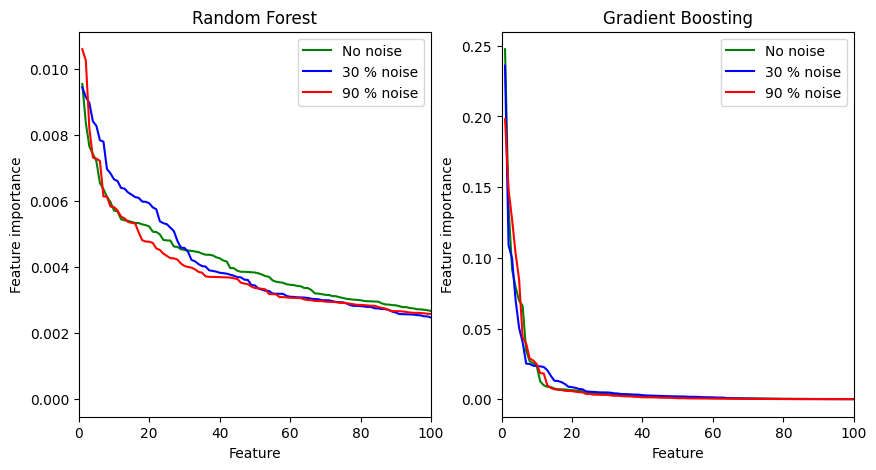

In [10]:
# Inspect feature importance 

#for i, noise in enumerate(noise_range):
#    print(f"Noise {noise}")
#    print(f"Gradient Boosting: Max: {np.max(feature_importance_gb[i])}, Mean: {np.mean(feature_importance_gb[i])}, Var: {np.var(feature_importance_gb[i])}, Significant Components: {len(np.where(feature_importance_gb[i] > 2*np.std(feature_importance_gb[i]))[0])}")
#    print(f"Random Forest: Max: {np.max(feature_importance_rf[i])}, Mean: {np.mean(feature_importance_rf[i])}, Var: {np.var(feature_importance_rf[i])}, Significant Components: {len(np.where(feature_importance_rf[i] > 2*np.std(feature_importance_rf[i]))[0])}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Random Forest")
plt.plot(np.arange(1, len(feature_importance_rf[0])+1), feature_importance_rf[0], 'g', label='No noise')
plt.plot(np.arange(1, len(feature_importance_rf[3])+1), feature_importance_rf[3], 'b', label='30 % noise')
plt.plot(np.arange(1, len(feature_importance_rf[-1])+1), feature_importance_rf[-1], 'r', label='90 % noise')
plt.xlim([0,100])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.legend()
plt.subplot(1,2,2)
plt.title("Gradient Boosting")
plt.plot(np.arange(1, len(feature_importance_gb[0])+1), feature_importance_gb[0], 'g', label='No noise')
plt.plot(np.arange(1, len(feature_importance_gb[3])+1), feature_importance_gb[3], 'b', label='30 % noise')
plt.plot(np.arange(1, len(feature_importance_gb[-1])+1), feature_importance_gb[-1], 'r', label='90 % noise')
plt.xlim([0,100])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.legend()
plt.show()